# Colab 환경설정

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os 
os.chdir('/content/gdrive/MyDrive/workspace/Suwon_pop/출산율예측/')

! pwd

/content/gdrive/MyDrive/workspace/Suwon_pop/출산율예측


# 데이터 로드

In [ ]:
! pip install smogn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import BaggingRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import probplot
from functools import reduce
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats
import smogn
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # Ignore FutureWarning

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
cmr = pd.read_csv("Data/CMR_2019.csv", encoding = 'euc-kr')
elmt = pd.read_csv("Data/ELMT_2019.csv", encoding = 'euc-kr')
frgn = pd.read_csv("Data/FRGN_2019.csv", encoding = 'euc-kr')
indp = pd.read_csv("Data/INDP_2019.csv", encoding = 'euc-kr')
kngd = pd.read_csv("Data/KNGD_2019.csv", encoding = 'euc-kr')
lndpr = pd.read_csv("Data/LNDPR_2019.csv", encoding = 'euc-kr')
old = pd.read_csv("Data/OLD_2019.csv", encoding = 'euc-kr')
strs = pd.read_csv("Data/STRS_2019.csv", encoding = 'euc-kr')
tl_emp = pd.read_csv("Data/TL_EMP_2019.csv", encoding = 'euc-kr')
wm_emp = pd.read_csv("Data/WM_EMP_2019.csv", encoding = 'euc-kr')
birth = pd.read_csv("Data/BIRTH_2020.csv", encoding = 'euc-kr')

df_name = [cmr,elmt,frgn,indp,kngd,lndpr,old,strs,tl_emp,wm_emp,birth]
model_data = reduce(lambda left, right: pd.merge(left,right, on='CITY'), df_name)

model_data.to_csv("TRAINING_SET.csv")
model_data.head()

,CITY,CMR,ELMT,FRGN,INDP,KNGD,LNDPR,OLD,STRS,TL_EMP,WM_EMP,BIRTH
0,수원시,5.1,99,33.95,48.1,192,0.328,10.4,29.1,0.654954,0.554120,0.796
1,성남시,4.8,72,18.69,58.1,127,0.559,13.3,26.5,0.632356,0.549513,0.767
2,의정부시,4.2,33,10.86,26.6,62,0.257,14.4,28.9,0.612533,0.524309,0.795
3,안양시,4.8,41,13.09,39.4,79,0.414,12.6,27.7,0.626890,0.543567,0.870
4,부천시,4.4,64,30.95,34.4,124,0.412,12.5,33.0,0.657677,0.598823,0.745


In [ ]:
cmr_test = pd.read_csv("Data/CMR_2020.csv", encoding = 'euc-kr')
elmt_test = pd.read_csv("Data/ELMT_2020.csv", encoding = 'euc-kr')
frgn_test = pd.read_csv("Data/FRGN_2020.csv", encoding = 'euc-kr')
indp_test = pd.read_csv("Data/INDP_2020.csv", encoding = 'euc-kr')
kngd_test = pd.read_csv("Data/KNGD_2020.csv", encoding = 'euc-kr')
lndpr_test = pd.read_csv("Data/LNDPR_2020.csv", encoding = 'euc-kr')
old_test = pd.read_csv("Data/OLD_2020.csv", encoding = 'euc-kr')
strs_test = pd.read_csv("Data/STRS_2020.csv", encoding = 'euc-kr')
tl_emp_test = pd.read_csv("Data/TL_EMP_2020.csv", encoding = 'euc-kr')
wm_emp_test = pd.read_csv("Data/WM_EMP_2020.csv", encoding = 'euc-kr')

predict_df_name = [cmr_test,elmt_test,frgn_test,indp_test,kngd_test,lndpr_test,old_test,strs_test,tl_emp_test,wm_emp_test]
predict_data = reduce(lambda left, right: pd.merge(left,right, on='CITY'), predict_df_name)

predict_data.to_csv("TEST_SET.csv")
predict_data.head()

,CITY,CMR,ELMT,FRGN,INDP,KNGD,LNDPR,OLD,STRS,TL_EMP,WM_EMP
0,수원시,4.7,99,30.21,45.9,189,0.398,11.1,27.4,0.638245,0.538246
1,성남시,4.6,72,16.15,60.5,123,0.326,14.2,27.7,0.628122,0.545751
2,의정부시,4.0,34,10.28,25.0,63,0.295,15.2,27.2,0.608099,0.505406
3,안양시,4.2,41,11.90,37.8,77,0.389,13.7,30.0,0.618783,0.525998
4,부천시,4.0,64,29.82,30.9,125,0.346,13.7,32.2,0.644966,0.575710


# EDA

In [ ]:
skewness = model_data.drop(['CITY'], axis=1).apply(lambda x: x.skew()).sort_values(ascending=False)
skewness

FRGN      1.019246
OLD       0.927363
KNGD      0.808000
ELMT      0.775159
CMR       0.745247
WM_EMP    0.674699
INDP      0.527966
TL_EMP    0.440550
LNDPR     0.398243
BIRTH     0.377927
STRS     -0.069683
dtype: float64

In [ ]:
kurtosis = model_data.drop(['CITY'], axis=1).apply(lambda x: x.kurt()).sort_values(ascending=False)
kurtosis

OLD       1.341786
INDP      1.100013
LNDPR     0.969685
TL_EMP    0.816488
WM_EMP    0.784112
FRGN      0.552463
STRS      0.182792
CMR       0.094182
ELMT     -0.257936
KNGD     -0.331110
BIRTH    -0.534216
dtype: float64

### 1) 변수간 상관관계 파악

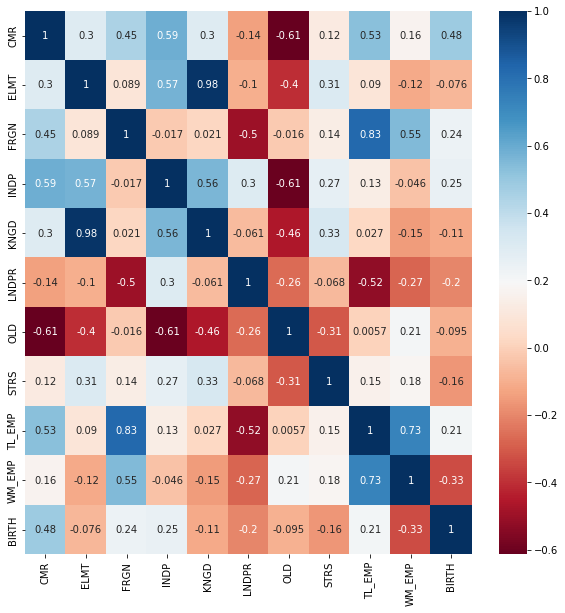

In [ ]:
cor_data = model_data.copy()
corr = cor_data[cor_data.columns.tolist()].corr()

plt.figure(figsize =(10,10))
sns.heatmap(corr,cmap='RdBu', annot = True)

- 변수 간 다중공선성 존재 확인 
- Feature Selection 적용

### 2) 결측값(Missing Value) 파악

In [ ]:
missing_col = model_data.columns[model_data.isnull().sum() > 0].to_list()

print('결측값 확인')
if len(missing_col) == 0:
    print("> 결측값 존재하지 않음")
else:
    print(model_data[missing_col].isnull().sum())

결측값 확인
> 결측값 존재하지 않음


### 3) 이상값(Oulier Value) 파악
- Tukey Fences
- Visualization

In [ ]:
def outlier_iqr(data, column): 

    global lower_limit, upper_limit    
    q25, q75 = np.quantile(data[column], 0.25), np.quantile(data[column], 0.75)          
    iqr = q75 - q25    
    lower_limit, upper_limit = q25 - iqr * 1.5, q75 + iqr * 1.5      
    
    upper_outlier = data[data[column] > upper_limit]     
    lower_outlier = data[data[column] < lower_limit]    
    
    
    return print(column,'이상값 수', upper_outlier.shape[0] + lower_outlier.shape[0])

이상값 확인
-------------------
CMR 이상값 수 0
ELMT 이상값 수 0
FRGN 이상값 수 0
INDP 이상값 수 2
KNGD 이상값 수 0
LNDPR 이상값 수 3
OLD 이상값 수 7
STRS 이상값 수 1
TL_EMP 이상값 수 2
WM_EMP 이상값 수 4
-------------------


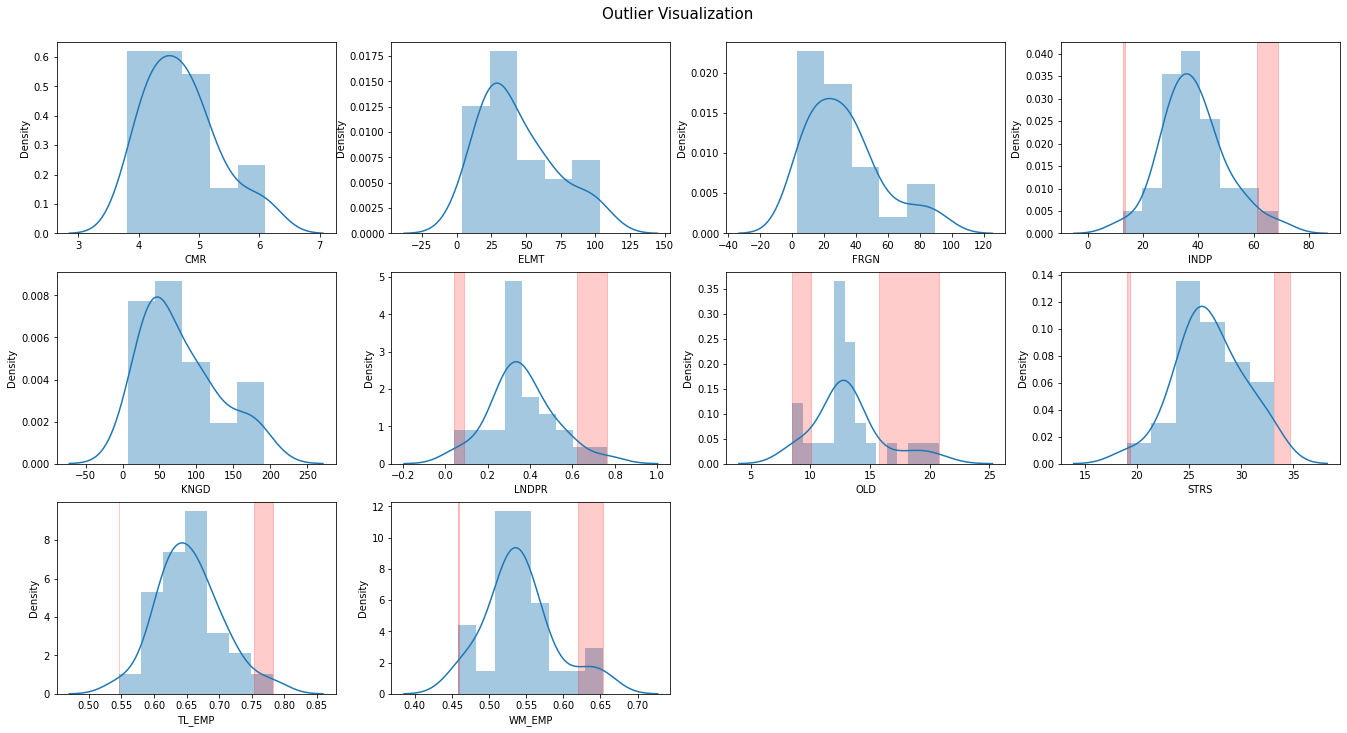

In [ ]:
print('이상값 확인')
print('-------------------')
fig = plt.figure(figsize = (23,12))
ax1 = fig.add_subplot(3,4,1)
outlier_iqr(model_data,'CMR')
sns.distplot(model_data['CMR'], ax = ax1)

ax2 = fig.add_subplot(3,4,2)
outlier_iqr(model_data,'ELMT')
sns.distplot(model_data['ELMT'], ax = ax2)

ax3 = fig.add_subplot(3,4,3)
outlier_iqr(model_data,'FRGN')
sns.distplot(model_data['FRGN'], ax = ax3)

ax4 = fig.add_subplot(3,4,4)
outlier_iqr(model_data,'INDP')
sns.distplot(model_data['INDP'], ax = ax4)
plt.axvspan(xmin=lower_limit, xmax=model_data.INDP.min(), alpha=0.2, color='red')
plt.axvspan(xmin=upper_limit, xmax=model_data.INDP.max(), alpha=0.2, color='red')

ax5 = fig.add_subplot(3,4,5)
outlier_iqr(model_data,'KNGD')
sns.distplot(model_data['KNGD'], ax = ax5)

ax6 = fig.add_subplot(3,4,6)
outlier_iqr(model_data,'LNDPR')
sns.distplot(model_data['LNDPR'], ax = ax6)
plt.axvspan(xmin=lower_limit, xmax=model_data.LNDPR.min(), alpha=0.2, color='red')
plt.axvspan(xmin=upper_limit, xmax=model_data.LNDPR.max(), alpha=0.2, color='red')

ax7 = fig.add_subplot(3,4,7)
outlier_iqr(model_data,'OLD')
sns.distplot(model_data['OLD'], ax = ax7)
plt.axvspan(xmin=lower_limit, xmax=model_data.OLD.min(), alpha=0.2, color='red')
plt.axvspan(xmin=upper_limit, xmax=model_data.OLD.max(), alpha=0.2, color='red')

ax8 = fig.add_subplot(3,4,8)
outlier_iqr(model_data,'STRS')
sns.distplot(model_data['STRS'], ax = ax8)
plt.axvspan(xmin=lower_limit, xmax=model_data.STRS.min(), alpha=0.2, color='red')
plt.axvspan(xmin=upper_limit, xmax=model_data.STRS.max(), alpha=0.2, color='red')

ax9 = fig.add_subplot(3,4,9)
outlier_iqr(model_data,'TL_EMP')
sns.distplot(model_data['TL_EMP'], ax = ax9)
plt.axvspan(xmin=lower_limit, xmax=model_data.TL_EMP.min(), alpha=0.2, color='red')
plt.axvspan(xmin=upper_limit, xmax=model_data.TL_EMP.max(), alpha=0.2, color='red')

ax10 = fig.add_subplot(3,4,10)
outlier_iqr(model_data,'WM_EMP')
print('-------------------')
sns.distplot(model_data['WM_EMP'], ax = ax10)
plt.axvspan(xmin=lower_limit, xmax=model_data.WM_EMP.min(), alpha=0.2, color='red')
plt.axvspan(xmin=upper_limit, xmax=model_data.WM_EMP.max(), alpha=0.2, color='red')

plt.suptitle('Outlier Visualization',fontsize=15, position=(0.5, 1 - 0.08))
plt.show()

# Data Preprocessing

### 1) Outlier Imputation

> IQR 기반 Winsorizing



In [ ]:
def outlier_fences(data, column):     
    
    q25, q75 = np.quantile(data[column], 0.25), np.quantile(data[column], 0.75)          
    iqr = q75 - q25    
    lower_limit, upper_limit = q25 - iqr * 1.5, q75 + iqr * 1.5      
    

    return data[column].clip(lower_limit,upper_limit, inplace = True)


outlier_fences(model_data,'INDP')
outlier_fences(model_data,'LNDPR')
outlier_fences(model_data,'OLD')
outlier_fences(model_data,'STRS')
outlier_fences(model_data,'TL_EMP')
outlier_fences(model_data,'WM_EMP')

### 2) Feature Selection
> Stepwise Selection

In [ ]:
VIF_check = model_data.drop(['CITY','BIRTH'], axis=1)

vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(VIF_check.values, i) for i in range(VIF_check.shape[1])]
vif["Features"] = VIF_check.columns
vif

,VIF,Features
0,229.722521,CMR
1,268.854691,ELMT
2,11.846034,FRGN
3,57.948136,INDP
4,241.238954,KNGD
5,14.890493,LNDPR
6,150.599531,OLD
7,88.278219,STRS
8,1118.762144,TL_EMP
9,475.888352,WM_EMP


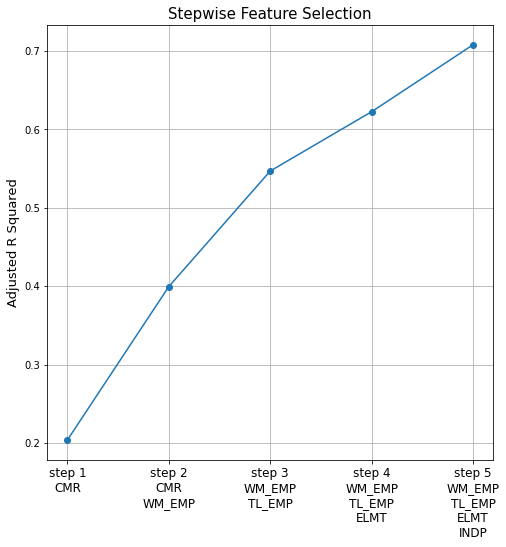

In [ ]:
variables = model_data.columns[1:-1].tolist()
y = model_data['BIRTH']
selected_variables = []

sv_per_step = [] # 각 스텝별로 선택된 변수들
adjusted_r_squared = [] # 각 스텝별 수정된 결정계수
steps = []
step = 0

while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder, dtype='float64')

    # 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 선형 모형을 적합
    for col in remainder: 
        X = model_data[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]

    # 최소 p-value 값이 기준 값보다 작으면 포함
    min_pval = pval.min()
    if min_pval < 0.05: #
        selected_variables.append(pval.idxmin())

        # 선택된 변수들에 대해서 어떤 변수를 제거할지 선택
        while len(selected_variables) > 0:
            selected_X = model_data[selected_variables]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y,selected_X).fit().pvalues[1:] ## 절편항의 p-value 제거

            # 최대 p-value값이 기준값보다 크거나 같으면 제외
            max_pval = selected_pval.max()
            if max_pval >= 0.05:
                remove_variable = selected_pval.idxmax()
                selected_variables.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(model_data[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
 
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=13)
plt.grid(True)
plt.title('Stepwise Feature Selection', fontsize=15)
plt.show()

selected_variables = model_data[selected_variables]
model_data = pd.concat([model_data['CITY'],selected_variables,model_data['BIRTH']], axis=1)

### 3) Feature Scaling

- StandardScaler

In [ ]:
def SCaler(data):
    raw_df = data.copy()

    categorical = pd.Series(raw_df['CITY'])
    target = pd.Series(raw_df['BIRTH'])
    df = raw_df.drop(['CITY','BIRTH'], axis=1)

    scaler = StandardScaler()
    scaler.fit(df)

    df_scaled = scaler.transform(df)
    feature_names = df.columns.tolist()
    scaled_data = pd.DataFrame(data=df_scaled, columns = feature_names)


    return pd.concat([categorical,scaled_data,target], axis=1)


def target_SCaler(feature, data):
    feature_df = feature.copy()
    raw_df = data.copy()

    df1 = feature_df.drop(['CITY','BIRTH'], axis=1)
# TL
    categorical = pd.Series(raw_df['CITY'])
    df = raw_df.loc[:,['WM_EMP','TL_EMP','ELMT','INDP']]

    scaler = StandardScaler()
    scaler.fit(df1)

    df_scaled = scaler.transform(df)
    feature_names = df.columns.tolist()
    scaled_data = pd.DataFrame(data=df_scaled, columns = feature_names)


    return pd.concat([categorical,scaled_data], axis=1)


train_data = SCaler(model_data)
predict_data = target_SCaler(model_data, predict_data)

# Modeling

### 1) Regeression Model
> Linear, Lasso, Ridge

Hold-Out

In [ ]:
feature_columns = train_data.columns[1:-1].tolist()
X = train_data[feature_columns]
y = train_data['BIRTH']         
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state= 42) 

print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(22, 4) (6, 4) (22,) (6,)


In [ ]:
linear_reg = LinearRegression()
lasso_reg = Lasso()
ridge_reg = Ridge()

# Regression
linear_model = linear_reg.fit(train_x, train_y)
linear_pred = linear_model.predict(test_x)

lasso_model = lasso_reg.fit(train_x, train_y)
lasso_pred = lasso_model.predict(test_x)

ridge_model = ridge_reg.fit(train_x, train_y)
ridge_pred = ridge_model.predict(test_x)


print("* Linear Regression")
print("RMSE: {}".format(sqrt(mean_squared_error(test_y, linear_pred))))
print('MAE: {}'.format(mean_absolute_error(test_y, linear_pred)))
print("R2: {}".format(r2_score(test_y,linear_pred)))
print("------------------------")
print("* Lasso Regression")
print("RMSE: {}".format(sqrt(mean_squared_error(test_y, lasso_pred))))
print('MAE: {}'.format(mean_absolute_error(test_y, lasso_pred)))
print("R2: {}".format(r2_score(test_y,lasso_pred)))
print("------------------------")
print("* Ridge Regression")
print("RMSE: {}".format(sqrt(mean_squared_error(test_y, ridge_pred))))
print('MAE: {}'.format(mean_absolute_error(test_y, ridge_pred)))
print("R2: {}".format(r2_score(test_y,ridge_pred)))

* Linear Regression
RMSE: 0.040845843529729024
MAE: 0.03452684057074523
R2: 0.6129241492344826
------------------------
* Lasso Regression
RMSE: 0.08078582285001326
MAE: 0.07427272727272728
R2: -0.5141560775928926
------------------------
* Ridge Regression
RMSE: 0.044459404604571665
MAE: 0.03961784463620044
R2: 0.5414067869628515


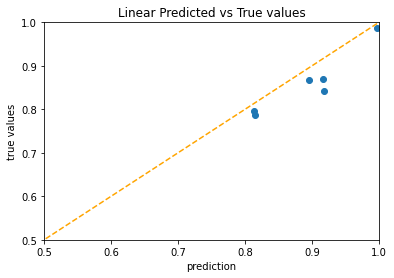

In [ ]:
plt.scatter(linear_pred, test_y)
plt.plot(np.linspace(0,40,40), np.linspace(0,40,40), c = 'orange', linestyle='--')
plt.xlabel('prediction')
plt.ylabel('true values')
plt.xlim(0.5,1)
plt.ylim(0.5,1)
plt.title('Linear Predicted vs True values')

plt.show()

### 2) 데이터 불균형 해소
> Bagging Regeression

In [ ]:
# Bagging Regression Using SMOGN
bagging_linear = BaggingRegressor(base_estimator = linear_reg, n_estimators = 12, random_state= 42).fit(train_x, train_y)
bagging_pred = bagging_linear.predict(test_x)

bagging_lasso = BaggingRegressor(base_estimator = lasso_reg, n_estimators = 12, random_state= 42).fit(train_x, train_y)
bagging_lasso_pred = bagging_lasso.predict(test_x)

bagging_ridge = BaggingRegressor(base_estimator = ridge_reg, n_estimators = 12, random_state= 42).fit(train_x, train_y)
bagging_ridge_pred = bagging_ridge.predict(test_x)


print("* Bagging Linear Regression")
print('RMSE: {}'.format(np.sqrt(mean_squared_error(test_y, bagging_pred))))
print('MAE: {}'.format(mean_absolute_error(test_y, bagging_pred)))
print('R-squared: {}'.format(r2_score(test_y, bagging_pred)))
print("------------------------")
print("* Bagging Lasso Regression")
print('RMSE: {}'.format(np.sqrt(mean_squared_error(test_y, bagging_lasso_pred))))
print('MAE: {}'.format(mean_absolute_error(test_y, bagging_lasso_pred)))
print('R-squared: {}'.format(r2_score(test_y, bagging_lasso_pred)))
print("------------------------")
print("* Bagging Ridge Regression")
print('RMSE: {}'.format(np.sqrt(mean_squared_error(test_y, bagging_ridge_pred))))
print('MAE: {}'.format(mean_absolute_error(test_y, bagging_ridge_pred)))
print('R-squared: {}'.format(r2_score(test_y, bagging_ridge_pred)))

* Bagging Linear Regression
RMSE: 0.047299467997427444
MAE: 0.04297720267153776
R-squared: 0.48094563168805526
------------------------
* Bagging Lasso Regression
RMSE: 0.08264816154349543
MAE: 0.07635858585858567
R-squared: -0.584771794665844
------------------------
* Bagging Ridge Regression
RMSE: 0.05550539747548432
MAE: 0.05134234934076994
R-squared: 0.2852226660083653


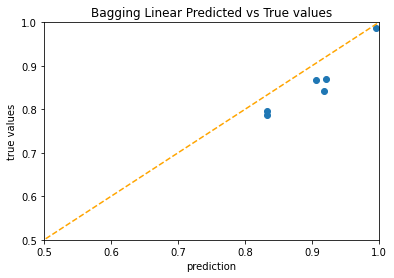

In [ ]:
plt.scatter(bagging_pred, test_y)
plt.plot(np.linspace(0,40,40), np.linspace(0,40,40), c = 'orange', linestyle='--')
plt.xlabel('prediction')
plt.ylabel('true values')
plt.xlim(0.5,1)
plt.ylim(0.5,1)
plt.title('Bagging Linear Predicted vs True values')

plt.show()

### 3) 과적합을 막기 위한 오버샘플링
> SMOGN - Synthetic Minority Over-Sampling Technique for Regression with Gaussian Noise

In [ ]:
# Dataset
train_data = train_data.drop('CITY',axis=1)
predict_data = predict_data.drop('CITY', axis=1)

In [ ]:
# SMOGN 적용
D_smogn = smogn.smoter(
    
    ## main arguments
    data = train_data,          
    y = 'BIRTH',        
    k = 4,                    ## positive integer (k < n)
    samp_method = 'extreme',  ## string ('balance' or 'extreme')

    ## phi relevance arguments
    rel_thres = 0.80,         ## positive real number (0 < R < 1)
    rel_method = 'auto',      ## string ('auto' or 'manual')
    rel_xtrm_type = 'low',   ## string ('low' or 'both' or 'high')
    rel_coef = 0.46          ## positive real number (0 < R)
)

print("\n\nRaw Data: {}".format(train_data.shape))
print("Oversampling Data: {}".format(D_smogn.shape))

r_index: 100%|##########| 4/4 [00:00<00:00, 574.48it/s]



Raw Data: (28, 5)
Oversampling Data: (38, 5)


In [ ]:
# Hold Out
feature_columns = D_smogn.columns[0:-1].tolist()
X = D_smogn[feature_columns]
y = D_smogn['BIRTH']         
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 42) 

print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(30, 4) (8, 4) (30,) (8,)


In [ ]:
# Regression Using SMOGN
linear_model = linear_reg.fit(X_train, y_train.ravel())
linear_pred_GN = linear_model.predict(x_test)

lasso_model = lasso_reg.fit(X_train, y_train.ravel())
lasso_pred_GN = lasso_model.predict(x_test)

ridge_model = ridge_reg.fit(X_train, y_train.ravel())
ridge_pred_GN = ridge_model.predict(x_test)

GN_rmse = np.sqrt(mean_squared_error(y_test, linear_pred_GN))
GN_mae = mean_absolute_error(y_test, linear_pred_GN)
GN_rr = r2_score(y_test, linear_pred_GN)

print("* Linear Regression")
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, linear_pred_GN))))
print('MAE: {}'.format(mean_absolute_error(y_test, linear_pred_GN)))
print('R-squared: {}'.format(r2_score(y_test, linear_pred_GN)))
print("------------------------")
print("* Lasso Regression")
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, lasso_pred_GN))))
print('MAE: {}'.format(mean_absolute_error(y_test, lasso_pred_GN)))
print('R-squared: {}'.format(r2_score(y_test, lasso_pred_GN)))
print("------------------------")
print("* Ridge Regression")
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, ridge_pred_GN))))
print('MAE: {}'.format(mean_absolute_error(y_test, ridge_pred_GN)))
print('R-squared: {}'.format(r2_score(y_test, ridge_pred_GN)))

* Linear Regression
RMSE: 0.0823217972664145
MAE: 0.06583409914382463
R-squared: 0.23712171053454834
------------------------
* Lasso Regression
RMSE: 0.09432251476815798
MAE: 0.07286789529365464
R-squared: -0.0015123542456574324
------------------------
* Ridge Regression
RMSE: 0.08279137824710492
MAE: 0.06276844386901209
R-squared: 0.22839364904629444


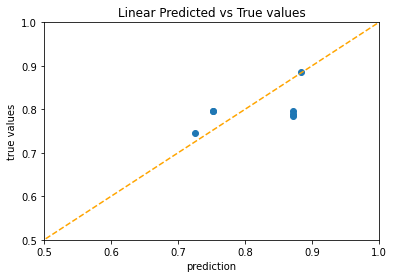

In [ ]:
plt.scatter(linear_pred_GN, y_test)
plt.plot(np.linspace(0,40,40), np.linspace(0,40,40), c = 'orange', linestyle='--')
plt.xlabel('prediction')
plt.ylabel('true values')
plt.xlim(0.5,1)
plt.ylim(0.5,1)
plt.title('Linear Predicted vs True values')

plt.show()

### 4) Leave-One-Out Cross-Validation

,count,mean,std,min,25%,50%,75%,max
RMSE,38.0,0.046026,0.036996,0.00057,0.019921,0.033752,0.069619,0.183042


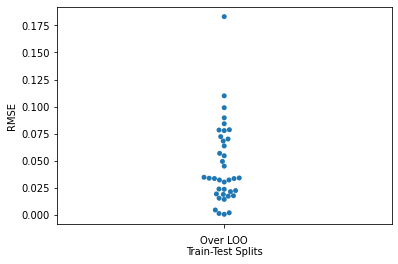

In [ ]:
X = D_smogn.drop(['BIRTH'], axis = 1)
y = D_smogn['BIRTH']

loo = LeaveOneOut()
rmse = cross_val_score(linear_reg, X, y, cv=loo, scoring='neg_mean_squared_error')

rmse = pd.Series(np.sqrt(-rmse))

rmse_df = pd.DataFrame({'RMSE':rmse})

rmse_df.index.name = 'Repeat'

display(rmse_df.describe().T)

ax = sns.swarmplot(y='RMSE', data=rmse_df)
ax.set_xlabel('Over LOO\nTrain-Test Splits');

In [ ]:
loo = LeaveOneOut()
X_array = np.array(X) #r stands for 'regression'
y_array = np.array(y)

ytests = []
ypreds = []
for train_idx, test_idx in loo.split(X):
    X_train, X_test = X_array[train_idx], X_array[test_idx] #requires arrays
    y_train, y_test = y_array[train_idx], y_array[test_idx]
    
    model = LinearRegression()
    model.fit(X = X_train, y = y_train) 
    y_pred = model.predict(X_test)
        
    # there is only one y-test and y-pred per iteration over the loo.split, 
    # so to get a proper graph, we append them to respective lists.
        
    ytests += list(y_test)
    ypreds += list(y_pred)
        
LOO_rr = r2_score(ytests, ypreds)
LOO_rmse = np.sqrt(mean_squared_error(ytests, ypreds))
LOO_mae = mean_absolute_error(ytests,ypreds)

print("Loocv Linear Regeression")
print('RMSE: {}'.format(LOO_rmse))
print('MAE: {}'.format(LOO_mae))
print('R-squared: {}'.format(LOO_rr))


print(model.coef_)

Loocv Linear Regeression
RMSE: 0.0587455266422007
MAE: 0.046025781338217935
R-squared: 0.45816743346762456
[-0.07965591  0.07212955 -0.04361727  0.01258364]


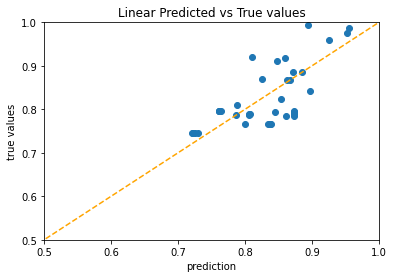

In [ ]:
plt.scatter(ypreds, ytests)
plt.plot(np.linspace(0,40,40), np.linspace(0,40,40), c = 'orange', linestyle='--')
plt.xlabel('prediction')
plt.ylabel('true values')
plt.xlim(0.5,1)
plt.ylim(0.5,1)
plt.title('Linear Predicted vs True values')

plt.show()

# 모형 검정

### 1) 예측 정확도

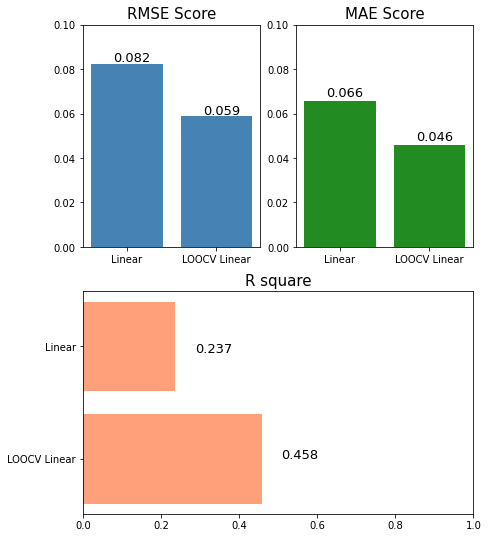

In [ ]:
rmse_score = [GN_rmse, LOO_rmse]
x_lab = ['Linear', 'LOOCV Linear']
plt.figure(figsize=(7,9))
plt.subplot(2,2,1)
plt.bar(x_lab, rmse_score, color = 'steelblue')
plt.title('RMSE Score', fontsize=15)
plt.ylim(0,0.1)
for i, v in enumerate(rmse_score):
    plt.text(i-0.15, v + 0.001, str(np.round(v,3)),fontsize=13)


MAE_score = [GN_mae, LOO_mae]
x_lab = ['Linear', 'LOOCV Linear']
plt.subplot(2,2,2)
plt.bar(x_lab, MAE_score, color = 'forestgreen')
plt.title('MAE Score', fontsize=15)
plt.ylim(0,0.1)
for i, v in enumerate(MAE_score):
    plt.text(i-0.15, v + 0.002, str(np.round(v,3)),fontsize=13)

r_score = [LOO_rr,GN_rr]
x_lab = ['LOOCV Linear', 'Linear']
plt.subplot(2,2,(3,4))
plt.barh(x_lab, r_score, color = 'lightsalmon')
rects = plt.barh(x_lab, r_score, color = 'lightsalmon')
plt.title('R square', fontsize=15)
plt.xlim(0,1)

r_text1 = [GN_rr]
r_text2 = [LOO_rr]
for i, v in enumerate(r_text1):
    plt.text( v+0.05,i+0.95, str(np.round(v,3)),fontsize=13)
for i, v in enumerate(r_text2):
    plt.text(v+0.05, i+0.005, str(np.round(v,3)),fontsize=13)

### 2) 회귀 모형 적합도 검정

2.1 모형 선형성 검정

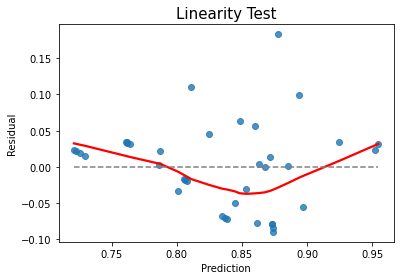

In [ ]:
y_test = np.array(ytests)
y_pred = np.array(ypreds)
residual = y_test - y_pred

sns.regplot(y_pred, residual, lowess=True, line_kws={'color': 'red'})
plt.plot([y_pred.min(), y_pred.max()], [0, 0], '--', color='grey')
plt.title('Linearity Test', fontsize=15)
plt.xlabel('Prediction')
plt.ylabel('Residual')
plt.show()

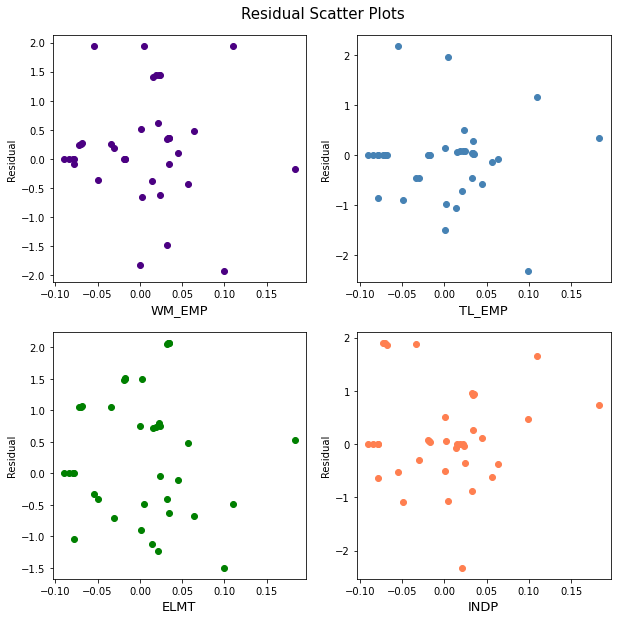

In [ ]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.scatter(residual,X['WM_EMP'], color ='indigo')
plt.xlabel('WM_EMP', fontsize = '13')
plt.ylabel('Residual')

plt.subplot(2,2,2)
plt.scatter(residual,X['TL_EMP'], color ='steelblue')
plt.xlabel('TL_EMP', fontsize = '13')
plt.ylabel('Residual')

plt.subplot(2,2,3)
plt.scatter(residual,X['ELMT'], color ='green')
plt.xlabel('ELMT', fontsize = '13')
plt.ylabel('Residual')

plt.subplot(2,2,4)
plt.scatter(residual,X['INDP'], color = 'coral')
plt.xlabel('INDP', fontsize = '13')
plt.ylabel('Residual')

plt.suptitle('Residual Scatter Plots',fontsize=15, position=(0.5, 1 - 0.08))
plt.show()

2.2 잔차 정규성 검정

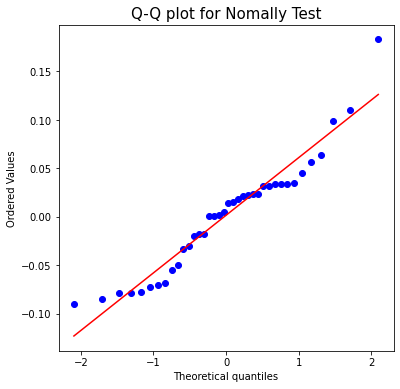

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
probplot(residual, dist='norm',plot=ax)
ax.set_title("Q-Q plot for Nomally Test", fontsize =15)

plt.show()

2.3 잔차 등분산성 검정

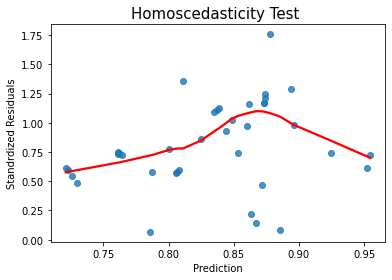

In [ ]:
sr = scipy.stats.zscore(residual)
sns.regplot(y_pred, np.sqrt(np.abs(sr)), lowess=True, line_kws={'color': 'red'})
plt.title('Homoscedasticity Test ', fontsize=15)
plt.xlabel('Prediction')
plt.ylabel('Standrdized Residuals')
plt.show()

2.4 잔차 독립성 검정

In [ ]:
VIF_check = X
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(VIF_check.values, i) for i in range(VIF_check.shape[1])]
vif["Features"] = VIF_check.columns
vif.index = ['1', '2', '3','4']

vif.style.set_caption(' Independence Test ').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('font-size', '16px'),
        ('border', '1px dotted grey')
    ]
}])

,VIF,Features
1,2.015167,WM_EMP
2,1.978889,TL_EMP
3,1.378636,ELMT
4,1.358900,INDP


# 모형 해석

### 1) 회귀 모형 시각화

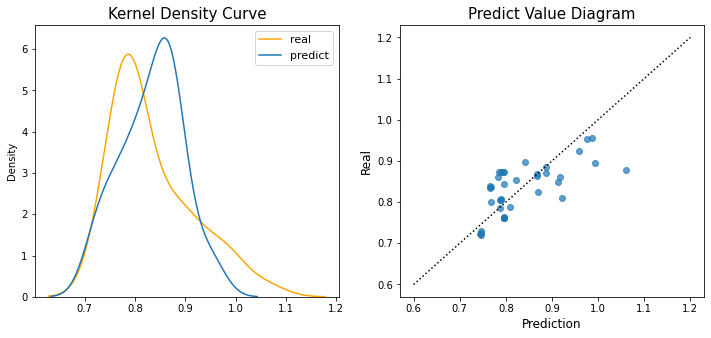

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(121)
ax1 = sns.distplot(y_test, hist=False, label='real', color = 'orange')
ax2 = sns.distplot(y_pred, hist=False, label='predict')
plt.title('Kernel Density Curve', fontsize = 15)
plt.legend(prop={'size': 11})


plt.subplot(122)
plt.scatter(y_test, y_pred, alpha = 0.7)
plt.plot(np.linspace(0.6,1.2), np.linspace(0.6,1.2), c = 'black', linestyle=':')
plt.title('Predict Value Diagram', fontsize = 15)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Real', fontsize=12)

plt.show()

### 2) 회귀식 해석

coefficient 해석

In [ ]:
cdf = pd.DataFrame(model.coef_, X.columns, columns=['Coefficients'])
cdf.head()

,Coefficients
WM_EMP,-0.079656
TL_EMP,0.072130
ELMT,-0.043617
INDP,0.012584


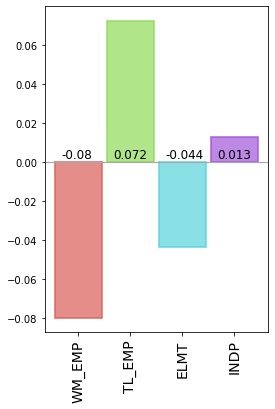

In [ ]:
model.coef_ = model.coef_.tolist()

plt.figure(figsize=(4,6))
colors = sns.color_palette('hls',len(model.coef_))
plt.bar(cdf.index, model.coef_, width=0.9, color = colors, edgecolor=colors, alpha=0.7, linewidth=2)
plt.axhline(y=0, color='darkgray', linewidth=1.2)
plt.xticks(cdf.index, fontsize=14, rotation=90);

for i, v in enumerate(model.coef_):
    plt.text(i-0.33, 0.002, np.round(v,3),fontsize=12)

In [ ]:
print('다중선형회귀식 : 𝒴 = ', np.round(model.intercept_,6), '+', '{}𝓍1'.format(np.round(model.coef_[0],4)), '+ {}𝓍2'.format(np.round(model.coef_[1],4)),
      '+ {}𝓍3'.format(np.round(model.coef_[2],4)), '+ {}𝓍4'.format(np.round(model.coef_[3],4)))
print('\n 𝒴 = 합계출산율, 𝓍1 = 여성고용률, 𝓍2 = 총고용률, 𝓍3 = 초등학교 수, 𝓍4 = 재정자립도' )

다중선형회귀식 : 𝒴 =  0.870994 + -0.0797𝓍1 + 0.0721𝓍2 + -0.0436𝓍3 + 0.0126𝓍4

 𝒴 = 합계출산율, 𝓍1 = 여성고용률, 𝓍2 = 총고용률, 𝓍3 = 초등학교 수, 𝓍4 = 재정자립도


### 3) 예측 합계출산율 도출

In [ ]:
real_pred = model.predict(predict_data)

In [ ]:
print('2021년 수원시 합계 출산율 예측값 : {}'.format(str(np.round(real_pred[0],3))))

2021년 수원시 합계 출산율 예측값 : 0.768
